<a href="https://colab.research.google.com/github/LilyMao/MelbourneHomePrice/blob/main/1_million_house.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [278]:
import pandas as pd
import numpy as np


Load the listing file retrieved from Domain

1.  This is a small dataset contains only 233 listings.
2.  The only columns useful here are 'suburb', 'propertyType', 'bedrooms',
'bathrooms', 'carspaces', 'price'





In [279]:
df_listings=pd.read_json('melbourne_listing.json')
df_listings.shape

(233, 20)

In [280]:
df_listings=df_listings[['suburb','propertyType','bedrooms','bathrooms','carspaces','price']]
df_listings

,suburb,propertyType,bedrooms,bathrooms,carspaces,price
0,Abbotsford,Townhouse,2,2.0,1.0,880000.0
1,Ascot Vale,House,4,1.0,1.0,NaN
2,Ashwood,House,3,1.0,2.0,1612000.0
3,Aspendale Gardens,House,4,2.0,2.0,NaN
4,Attwood,House,4,1.0,2.0,780000.0
...,...,...,...,...,...,...
228,Werribee,House,4,2.0,2.0,700000.0
229,Werribee,House,4,2.0,2.0,550000.0
230,Wyndham Vale,House,3,1.0,2.0,450000.0
231,Yarraville,House,4,2.0,2.0,NaN


In [281]:
df_listings.isna().sum()

suburb            0
propertyType      0
bedrooms          0
bathrooms         3
carspaces         3
price           105
dtype: int64

105 prices are not available, this is reasonable as for many properties we need to contact agent to have a price guide. Here since we have quite small dataset, drop all nas is not an option. I choose to fill the missing values with the median price of the indicated surburb.

In [282]:
df_listings.sort_values(by='suburb',inplace=True)

In [283]:
df_medians=pd.read_excel('House_Medians3rdQtr2020.xls',skiprows=1)
df_medians

,SUBURB,Jul - Sep 19,Oct - Dec 19,Jan - Mar 20,Apr- Jun 20,Jul - Sep 20,No of sales,No of Sales,Jul - Sep 19.1,Apr - Jun 20
0,NaN,NaN,NaN,NaN,NaN,NaN,Jul - Sep 20,YTD,Jul - Sep 20,Jul - Sep 20
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ABBOTSFORD,1160000,1027500.0,1230000.0,1080000.0,1260000.0,8,33,8.6,16.7
3,ABERFELDIE,1352500,1650000.0,1732500.0,1375000.0,1600000.0,6,25,18.3,16.4
4,AINTREE,575000,620400.0,675000.0,685000.0,740000.0,8,52,28.7,8.0
...,...,...,...,...,...,...,...,...,...,...
758,YARRAM,224000,249800.0,259000.0,247500.0,241000.0,11,37,7.6,-2.6
759,YARRAVILLE,1010000,986000.0,952500.0,1050000.0,960100.0,26,106,-4.9,-8.6
760,YARRAWONGA,372500,389800.0,398000.0,452500.0,482500.0,42,107,29.5,6.6
761,YEA,470500,420000.0,395000.0,421300.0,495000.0,6,21,5.2,17.5


I am only interested in the suburb and median price in this file. 

In [284]:
df_medians=df_medians[['SUBURB','Jul - Sep 20']]
df_medians

,SUBURB,Jul - Sep 20
0,NaN,NaN
1,NaN,NaN
2,ABBOTSFORD,1260000.0
3,ABERFELDIE,1600000.0
4,AINTREE,740000.0
...,...,...
758,YARRAM,241000.0
759,YARRAVILLE,960100.0
760,YARRAWONGA,482500.0
761,YEA,495000.0


In [285]:
df_medians.dropna(inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Here I would change all values in SUBURB to title format, so that I can match them with suburbs in the df_listings. Then we merge df_listings and df_medians, fill the NA in 'price' with the median price indicated in df_medians.

In [286]:
df_medians['SUBURB']=df_medians['SUBURB'].apply(lambda x:x.title())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [287]:
with_medianprice=df_listings.merge(df_medians,left_on='suburb',right_on='SUBURB',how='left')

In [288]:
with_medianprice['price']=with_medianprice['price'].fillna(with_medianprice['Jul - Sep 20'])


Now most prices are filled. 2 prices are not matched. And some listings do not have bedroom and bathroom numbers, I would drop them. After drop, I have 224 property listings.

In [289]:
set(with_medianprice['suburb'].unique())-set(with_medianprice['SUBURB'].unique())

{'Newtown', 'Rippleside', 'Thomson'}

In [290]:
with_medianprice.isna().sum()

suburb          0
propertyType    0
bedrooms        0
bathrooms       3
carspaces       3
price           2
SUBURB          6
Jul - Sep 20    6
dtype: int64

In [291]:
with_medianprice.dropna(inplace=True)

In [292]:
with_medianprice.shape

(224, 8)

In [293]:
with_medianprice.isna().sum()

suburb          0
propertyType    0
bedrooms        0
bathrooms       0
carspaces       0
price           0
SUBURB          0
Jul - Sep 20    0
dtype: int64

In [294]:
len(with_medianprice['suburb'].unique())

139

Since we have 139 unique suburbs in listings, to use them as a feature, I would rank them to 'high', 'medium' and 'low' priced suburbs, based on the distributions of median price. Suburbs rank 'high' if their median price is over 0.75 quantile, rank 'low' if median price below 0.25 quantile, 'median' otherwise.

In [295]:
with_medianprice['Jul - Sep 20'].describe()

count    2.240000e+02
mean     9.863312e+05
std      5.448811e+05
min      1.950000e+05
25%      6.150000e+05
50%      8.263000e+05
75%      1.165000e+06
max      3.325000e+06
Name: Jul - Sep 20, dtype: float64

In [296]:
mask_high=(with_medianprice['Jul - Sep 20']>=1.160000e+06)
mask_medium=((with_medianprice['Jul - Sep 20']>=6.150000e+05)&(with_medianprice['Jul - Sep 20']<=1.160000e+06))
mask_low=(with_medianprice['Jul - Sep 20']<=6.150000e+05)


In [297]:
with_medianprice.loc[with_medianprice[mask_high].index,'suburb_rank']='high'
with_medianprice.loc[with_medianprice[mask_medium].index,'suburb_rank']='medium'
with_medianprice.loc[with_medianprice[mask_low].index,'suburb_rank']='low'

Okay, we have new column 'suburb_rank' to replace 'suburb'.

In [298]:
with_medianprice

,suburb,propertyType,bedrooms,bathrooms,carspaces,price,SUBURB,Jul - Sep 20,suburb_rank
0,Abbotsford,Townhouse,2,2.0,1.0,880000.0,Abbotsford,1260000.0,high
1,Ascot Vale,House,4,1.0,1.0,1328800.0,Ascot Vale,1328800.0,high
2,Ashwood,House,3,1.0,2.0,1612000.0,Ashwood,1210500.0,high
3,Aspendale Gardens,House,4,2.0,2.0,1002500.0,Aspendale Gardens,1002500.0,medium
4,Attwood,House,4,1.0,2.0,780000.0,Attwood,714000.0,medium
...,...,...,...,...,...,...,...,...,...
228,Werribee,House,4,2.0,2.0,700000.0,Werribee,518000.0,low
229,Werribee,House,4,2.0,2.0,550000.0,Werribee,518000.0,low
230,Wyndham Vale,House,3,1.0,2.0,450000.0,Wyndham Vale,482500.0,low
231,Yarraville,House,4,2.0,2.0,960100.0,Yarraville,960100.0,medium


In [299]:
with_medianprice.drop(columns=['SUBURB','Jul - Sep 20','suburb'],inplace=True)

Draw a boxplot to see how price distributed. Around half of them are over 1 millon.

In [300]:
import matplotlib.pyplot as plt


{'boxes': [<matplotlib.lines.Line2D at 0x7fde99a24650>],
 'caps': [<matplotlib.lines.Line2D at 0x7fde999f8f50>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fde999f94d0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fde999f8fd0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7fde999f65d0>,
  <matplotlib.lines.Line2D at 0x7fde999f6990>]}

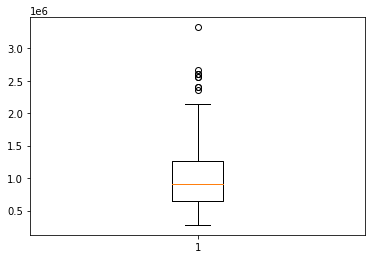

In [301]:
plt.boxplot(with_medianprice['price'])

In [302]:
mask=with_medianprice['price']>1000000
mask

0      False
1       True
2       True
3       True
4      False
       ...  
228    False
229    False
230    False
231    False
232    False
Name: price, Length: 224, dtype: bool

Now I label the price over 1 million as '1', otherwise 0.

In [303]:
with_medianprice.loc[mask,'price']=1



In [304]:
with_medianprice.loc[~mask,'price']=0

In [305]:
with_medianprice['price'].value_counts()

0.0    130
1.0     94
Name: price, dtype: int64

In [306]:
with_medianprice

,propertyType,bedrooms,bathrooms,carspaces,price,suburb_rank
0,Townhouse,2,2.0,1.0,0.0,high
1,House,4,1.0,1.0,1.0,high
2,House,3,1.0,2.0,1.0,high
3,House,4,2.0,2.0,1.0,medium
4,House,4,1.0,2.0,0.0,medium
...,...,...,...,...,...,...
228,House,4,2.0,2.0,0.0,low
229,House,4,2.0,2.0,0.0,low
230,House,3,1.0,2.0,0.0,low
231,House,4,2.0,2.0,0.0,medium


In [307]:
X=with_medianprice.drop(columns='price')
y=with_medianprice['price']

In [308]:
y

0      0.0
1      1.0
2      1.0
3      1.0
4      0.0
      ... 
228    0.0
229    0.0
230    0.0
231    0.0
232    0.0
Name: price, Length: 224, dtype: float64

After encoding, this is our final dataframe to use to build classification model.

In [309]:
X=pd.get_dummies(X,columns=['propertyType','suburb_rank'],prefix=['propertyType','suburb_rank'],drop_first=True)
X

,bedrooms,bathrooms,carspaces,propertyType_Townhouse,propertyType_Unit,suburb_rank_low,suburb_rank_medium
0,2,2.0,1.0,1,0,0,0
1,4,1.0,1.0,0,0,0,0
2,3,1.0,2.0,0,0,0,0
3,4,2.0,2.0,0,0,0,1
4,4,1.0,2.0,0,0,0,1
...,...,...,...,...,...,...,...
228,4,2.0,2.0,0,0,1,0
229,4,2.0,2.0,0,0,1,0
230,3,1.0,2.0,0,0,1,0
231,4,2.0,2.0,0,0,0,1


In [310]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=42)

In [311]:
from sklearn.ensemble import RandomForestClassifier
rf_clf=RandomForestClassifier()
rf_clf.fit(X_train,y_train)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

I use randomforest here, generate moderately accurate model.

In [312]:
print (f'Train Accuracy - : {rf_clf.score(X_train,y_train):.3f}')
print (f'Test Accuracy - : {rf_clf.score(X_test,y_test):.3f}')

Train Accuracy - : 0.899
Test Accuracy - : 0.768


In [313]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

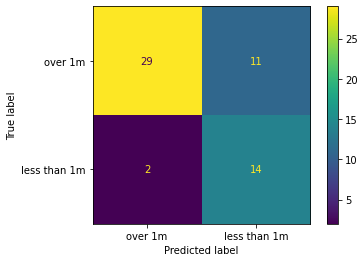

In [314]:
#plot confusion matrix
plot_confusion_matrix(rf_clf,X_test,y_test,display_labels=["over 1m","less than 1m"])

Finally, I will use this model to predict my friends' house price; It was house, has 3 bedrooms, 2 bathrooms, 2 carparks, and it locates in a suburb ranks medium. Hooray! It worths more than one million now!

In [315]:
rf_clf.predict([[3,2,2,0,0,0,1]])

array([1.])